In [1]:
# Import section libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from matplotlib.pyplot import rcParams
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, pacf

In [2]:
# Some settings

# PATH

PATH = '../../Raw Data sets/Sauti Africa Market Monitoring/eac-ratin.csv'

# Size of plottings

rcParams['figure.figsize'] = 20,6

In [3]:
prices = pd.read_csv(PATH)

In [4]:
prices.head()

,Market,Product,Country,Date,Retail (MT),Wholesale (MT),Currency
0,Bujumbura,Maize,Burundi,10/4/2011,0,548798,BIF
1,Bujumbura,Maize,Burundi,10/5/2011,0,549000,BIF
2,Bujumbura,Maize,Burundi,10/6/2011,0,498970,BIF
3,Bujumbura,Maize,Burundi,10/7/2011,0,549299,BIF
4,Bujumbura,Maize,Burundi,10/10/2011,0,549872,BIF


In [101]:
# There are duplicated dates!

lira = prices[prices['Market'] == 'Lira']
print(lira.shape)
lira[['Date']].nunique()

(2397, 7)


Date    1949
dtype: int64

In [104]:
# drop duplicated rows in terms of Dates.
lira = lira.drop(labels=lira[lira.duplicated(['Date'], keep='first')].index, axis=0)

In [106]:
lira['Date'] = pd.to_datetime(lira['Date'], infer_datetime_format=True)
lira = lira.set_index('Date')
lira = lira[['Wholesale (MT)']].astype(float) / 1000
lira = lira[lira.index >= '2010-12-31']
lira.head()

,Wholesale (MT)
Date,
2011-03-04,499.489
2011-03-07,499.655
2011-03-10,500.561
2011-03-15,494.353
2011-03-21,498.928


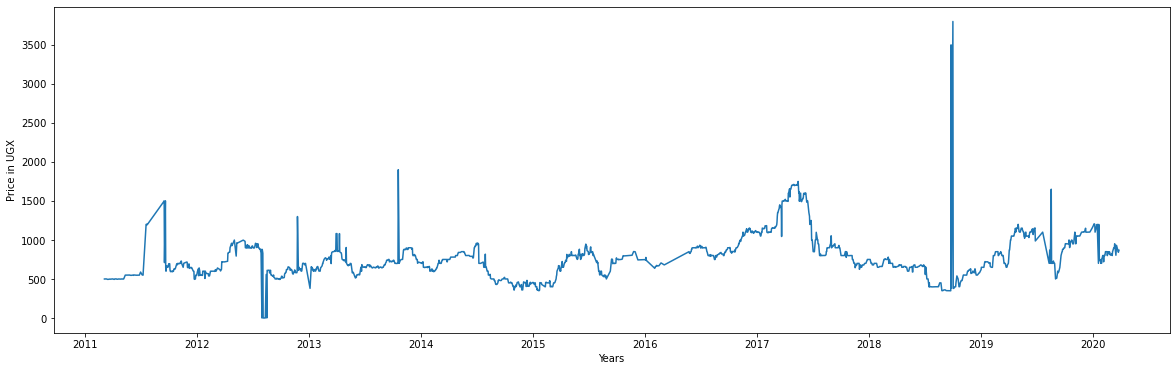

In [107]:

timeseries_prices = plt.plot(lira['Wholesale (MT)'], label = 'Maize Price')
# upper_band = plt.plot(month_rolmean + 2 * month_rolstd, color='red', label='Crisis band')
# lower_band = plt.plot(month_rolmean + 1.5 * month_rolstd, color='orange', label='Alert mean')
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()



In [108]:
# I'm building a dataframe with all the possible dates between start='2/27/2011', end='3/28/2020'.

dummy = pd.DataFrame()
dummy['dates'] = pd.date_range(start='2/28/2011', end='3/29/2020')
dummy = dummy.set_index('dates')
lira = dummy.merge(lira, how='outer', left_index=True, right_index=True)
print(dummy.shape)
lira.shape

(3318, 0)


(3318, 1)

In [109]:
# Searching to the outliers.

z = np.abs(stats.zscore(lira['Wholesale (MT)'], nan_policy='omit'))


dates_to_drop = [lira.iloc[i:i+1,:].index[0] for i in list(np.where(z>4)[0])]
lira = lira.drop(dates_to_drop, axis=0)

C:\Users\jcm\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [110]:
lira['mean_price_7days'] = lira['Wholesale (MT)'].rolling(window=7,min_periods=1).mean()
# lira['std_price_7days'] = lira['Wholesale (MT)'].rolling(window=7,min_periods=2).std()

lira['number_of_day'] = [i%7 +1 for i in range(len(lira))]

# lira['difference'] = np.where(lira['Wholesale (MT)'] >= (lira['mean_price_7days'] + 2*lira['std_price_7days']), 'Yes','No' )
print(lira.shape)
lira.head(25)

(3315, 3)


,Wholesale (MT),mean_price_7days,number_of_day
2011-02-28,NaN,NaN,1
2011-03-01,NaN,NaN,2
2011-03-02,NaN,NaN,3
2011-03-03,NaN,NaN,4
2011-03-04,499.489,499.489000,5
2011-03-05,NaN,499.489000,6
2011-03-06,NaN,499.489000,7
2011-03-07,499.655,499.572000,1
2011-03-08,NaN,499.572000,2
2011-03-09,NaN,499.572000,3


In [111]:
lira.tail(25)

,Wholesale (MT),mean_price_7days,number_of_day
2020-03-05,800.240,808.239000,1
2020-03-06,847.486,822.575667,2
2020-03-07,NaN,822.575667,3
2020-03-08,NaN,822.575667,4
2020-03-09,NaN,822.575667,5
2020-03-10,899.079,848.935000,6
2020-03-11,NaN,848.935000,7
2020-03-12,900.343,882.302667,1
2020-03-13,950.518,916.646667,2
2020-03-14,NaN,916.646667,3


In [112]:
# looking for weeks with no values at all.

lira[lira['number_of_day'] == 7]['mean_price_7days'][lira[lira['number_of_day'] == 7]['mean_price_7days'].isnull()]

2011-05-22   NaN
2011-07-17   NaN
2011-07-31   NaN
2011-08-07   NaN
2011-08-14   NaN
2011-08-21   NaN
2011-08-28   NaN
2011-09-04   NaN
2011-09-11   NaN
2011-11-27   NaN
2012-05-20   NaN
2012-05-27   NaN
2012-12-30   NaN
2015-09-07   NaN
2015-11-02   NaN
2015-11-09   NaN
2015-11-16   NaN
2015-12-07   NaN
2015-12-21   NaN
2015-12-28   NaN
2016-01-18   NaN
2016-01-25   NaN
2016-02-01   NaN
2016-03-14   NaN
2016-03-21   NaN
2016-03-28   NaN
2016-04-04   NaN
2016-04-11   NaN
2016-04-18   NaN
2016-04-25   NaN
2016-05-02   NaN
2016-05-09   NaN
2016-05-16   NaN
2016-05-23   NaN
2019-07-10   NaN
2019-07-17   NaN
2019-07-31   NaN
Name: mean_price_7days, dtype: float64

In [125]:
# filling those gaps

weekly_lira = pd.DataFrame(lira[lira['number_of_day'] == 7]['mean_price_7days'].interpolate())
weekly_lira = weekly_lira.set_index(pd.date_range(start='2011-03-06', periods=len(weekly_lira), freq='w'))
weekly_lira

,mean_price_7days
2011-03-06,499.489000
2011-03-13,500.108000
2011-03-20,494.353000
2011-03-27,498.218750
2011-04-03,500.078500
...,...
2020-02-23,841.388250
2020-03-01,812.238500
2020-03-08,848.935000
2020-03-15,884.899667


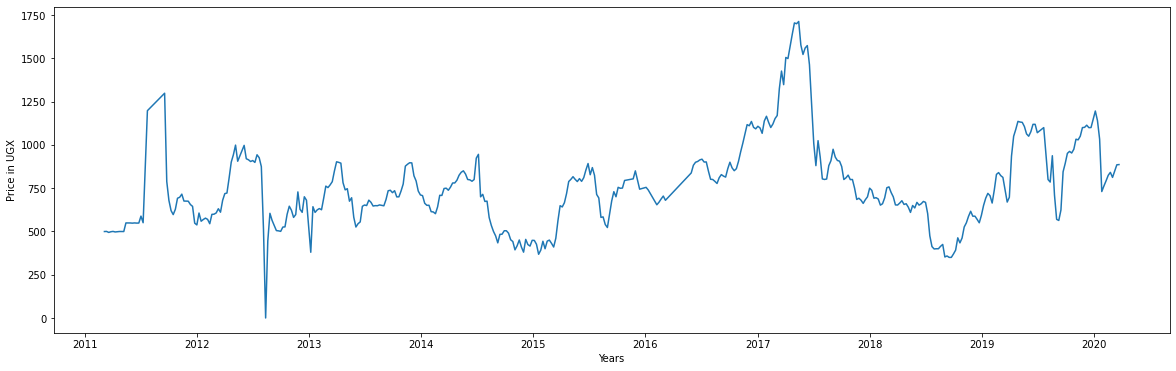

In [118]:
timeseries_prices = plt.plot(weekly_lira, label = 'Maize Price')
# upper_band = plt.plot(month_rolmean + 2 * month_rolstd, color='red', label='Crisis band')
# lower_band = plt.plot(month_rolmean + 1.5 * month_rolstd, color='orange', label='Alert mean')
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()


In [119]:
# Augmented Dickey-Fuller test


'''
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.
The intuition behind a unit root is that it determines how strongly a time series is defined by a trend.
The more negative the statistic is, the more likely to reject the null hypothesis, this mean, 
    the data has a unit root and is non-stationary. It has some time dependency.
'''


result_adft = adfuller(weekly_lira)
print(f'ADF Statistic: {round(result_adft[0],4)}')
print(f'p-value: {round(result_adft[1],4)}')
print('Critical Values:')
for key, value in result_adft[4].items():
    print(f'{key}: {round(value,4)}')

ADF Statistic: -3.6293
p-value: 0.0052
Critical Values:
1%: -3.4443
5%: -2.8677
10%: -2.5701


The statistic is lower than all the critical values, so I reject the Null Hypothesis with a confidence of 99%, meaning that the Time Series is stationary.

## ACF 

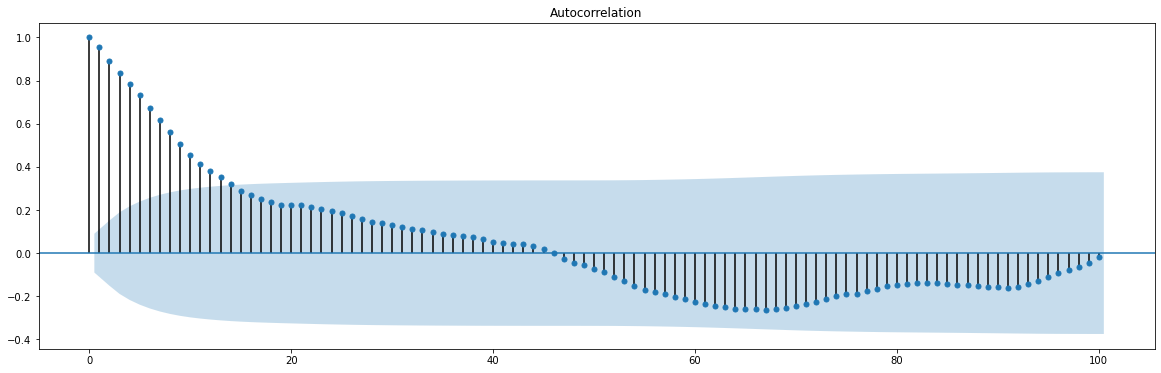

In [120]:
acf_plot = plot_acf(weekly_lira, lags=100)

## PACF

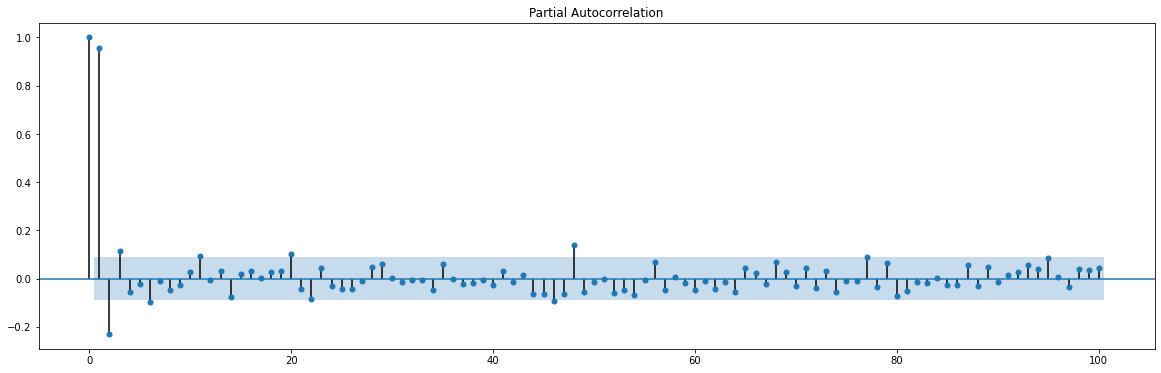

In [121]:
pacf_plot = plot_pacf(weekly_lira, lags=100)

In [163]:
# First approach to splitting the data into train and testing set.


train_end = datetime(2020,3,1)
test_end = datetime(2020,3,22)

train_data = weekly_lira[:train_end]
test_data = weekly_lira[train_end + timedelta(days=1):test_end]


In [167]:
# Create the model

premodel = ARIMA(train_data, order=(2,0,2))
model = premodel.fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       mean_price_7days   No. Observations:                  470
Model:                     ARMA(2, 2)   Log Likelihood               -2667.078
Method:                       css-mle   S.D. of innovations             70.311
Date:                Sat, 09 May 2020   AIC                           5346.157
Time:                        01:11:37   BIC                           5371.073
Sample:                    03-06-2011   HQIC                          5355.960
                         - 03-01-2020                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    759.1793     60.555     12.537      0.000     640.494     877.865
ar.L1.mean_price_7days     0.1590      0.294      0.541      0.588      -0.416       0.734
ar.L2.mean_price_7days     0.7254      0.270      2.692      0.007       0.197       1.254
ma.L1.mean_price_7days     1.0477      0.305      3.437      0.001       0.450       1.645
ma.L2.mean_price_7days     0.1764      0.124      1.423      0.155      -0.067       0.419
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0696           +0.0000j            1.0696            0.0000
AR.2           -1.2888           +0.0000j            1.2888            0.5000
MA.1           -1.1949           +0.0000j            1.1949            0.5000
MA.2           -4.7442           +0.0000j            4.7442            0.5000
-----------------------------------------------------------------------------
"""

In [168]:
# predictions time

pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = model.predict(start=pred_start_date, end=pred_end_date)

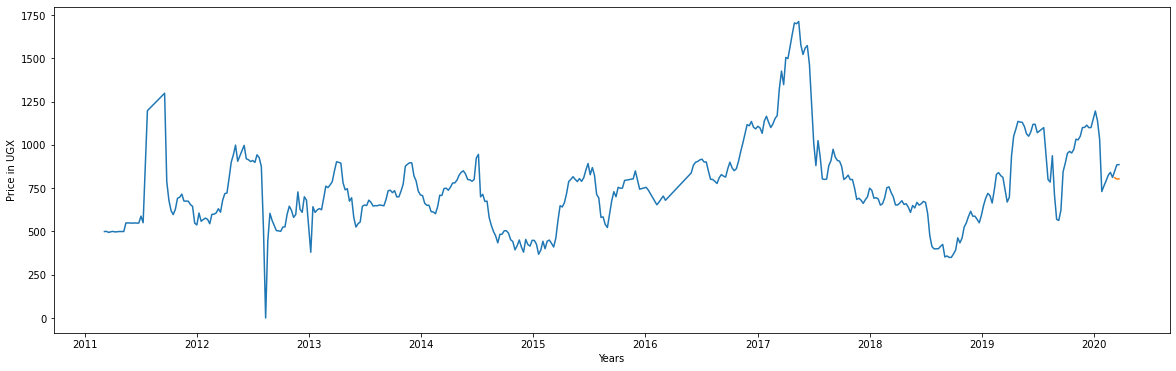

In [169]:
timeseries_prices = plt.plot(weekly_lira, label = 'Maize Price')
plt.plot(predictions, label='predictions')
# upper_band = plt.plot(month_rolmean + 2 * month_rolstd, color='red', label='Crisis band')
# lower_band = plt.plot(month_rolmean + 1.5 * month_rolstd, color='orange', label='Alert mean')
plt.xlabel('Years')
plt.ylabel('Price in UGX')
plt.show()


,dates
0,2011-02-27
1,2011-02-28
2,2011-03-01
3,2011-03-02
4,2011-03-03


,mean_price_7days
2011-03-06,NaN
2011-03-13,NaN
2011-03-20,NaN
2011-03-27,NaN
2011-04-03,NaN
...,...
2020-02-23,NaN
2020-03-01,NaN
2020-03-08,NaN
2020-03-15,NaN


DatetimeIndex(['2011-03-06', '2011-03-13', '2011-03-20', '2011-03-27',
               '2011-04-03', '2011-04-10', '2011-04-17', '2011-04-24',
               '2011-05-01', '2011-05-08',
               ...
               '2021-04-04', '2021-04-11', '2021-04-18', '2021-04-25',
               '2021-05-02', '2021-05-09', '2021-05-16', '2021-05-23',
               '2021-05-30', '2021-06-06'],
              dtype='datetime64[ns]', length=536, freq='W-SUN')

2011-03-05    499.489000
2011-03-12    500.108000
2011-03-19    494.353000
2011-03-26    498.218750
2011-04-02    500.078500
                 ...    
2020-02-28    824.239667
2020-03-05    813.414000
2020-03-12    882.302667
2020-03-19    894.993000
2020-03-26    842.071000
Name: mean_price_7days, Length: 536, dtype: float64